In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import corner
import math
import csv
from numpy import *

import matplotlib
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import sklearn.metrics as metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image
from fpdf import FPDF
from PIL import Image
import pydotplus
from scipy.stats import gaussian_kde

%matplotlib inline
import graphviz
from sklearn import tree
from xgboost import plot_tree
from sklearn.tree import DecisionTreeClassifier

In [2]:
planets = pd.read_csv('2-3 mm.csv', skipinitialspace=True)

print(planets.columns)

Index(['run', 'planet', 'cv e', 'cv a', 'cv peri', 'cv i', 'initial e',
       'final e', 'mean e', 'min e', 'max e', 'sd e', 'initial i', 'final i',
       'mean i', 'min i', 'max i', 'sd i', 'initial pericenter',
       'final pericenter', 'mean pericenter', 'min pericenter',
       'max pericenter', 'sd pericenter', 'initial jacobi', 'final jacobi',
       'mean jacobi', 'min jacobi', 'max jacobi', 'sd jacobi', 'initial mhr1',
       'final mhr1', 'mean mhr1', 'min mhr1', 'max mhr1', 'sd mhr1',
       'initial mhr2', 'final mhr2', 'mean mhr2', 'min mhr2', 'max mhr2',
       'sd mhr2', 'initial log a1_ratio', 'final log a1_ratio',
       'mean log a1_ratio', 'min log a1_ratio', 'max log a1_ratio',
       'sd log a1_ratio', 'initial log a2_ratio', 'final log a2_ratio',
       'mean log a2_ratio', 'min log a2_ratio', 'max log a2_ratio',
       'sd log a2_ratio', 'initial log mass1_ratio', 'final log mass1_ratio',
       'mean log mass1_ratio', 'min log mass1_ratio', 'max log mass1_rati

## refining features

In [12]:
features_train, features_test, classes_train, classes_test = train_test_split(planets, classes, test_size=0.3, random_state=1)

ru = features_test['run'].to_numpy()
p = features_test['planet'].to_numpy()
e = features_test['end time'].to_numpy()
fa = features_test['fate'].to_numpy()

d = ['run', 'planet', 'fate', 'end time']
 
ids_train = features_train['planet'].to_numpy()
features_train.drop(d, axis=1, inplace=True)

cols = features_train.columns
features_train = features_train.to_numpy()

ids_test = features_test['planet'].to_numpy()
features_test.drop(d, axis=1, inplace=True)
features_test = features_test.to_numpy()

f = planets.columns.drop(d)

/Users/neha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
classifier = GradientBoostingClassifier(random_state=1)

In [14]:
n_features_to_select = 1
rfe = RFE(classifier, n_features_to_select)
rfe.fit(features_train, classes_train)

from operator import itemgetter
for x, y in (sorted(zip(rfe.ranking_ , f), key=itemgetter(0))):
    print(x, y)

/Users/neha/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


1 initial log mass1_ratio
2 cv peri
3 min log mass2_ratio
4 max e
5 min log mass1_ratio
6 sd e
7 sd mhr1
8 max jacobi
9 mean log mass1_ratio
10 initial log mass2_ratio
11 cv i
12 mean log a1_ratio
13 max mhr1
14 sd pericenter
15 final pericenter
16 final log mass2_ratio
17 sd mhr2
18 final log mass1_ratio
19 min log a1_ratio
20 min e
21 sd i
22 mean jacobi
23 sd log a1_ratio
24 mean e
25 sd jacobi
26 sd log a2_ratio
27 max pericenter
28 initial mhr2
29 max i
30 max log mass2_ratio
31 mean log a2_ratio
32 mean mhr1
33 min pericenter
34 final log a1_ratio
35 final mhr1
36 max log a1_ratio
37 max mhr2
38 final i
39 final e
40 cv e
41 max log mass1_ratio
42 min mhr1
43 final log a2_ratio
44 mean mhr2
45 min log a2_ratio
46 initial jacobi
47 final jacobi
48 initial log a1_ratio
49 max log a2_ratio
50 mean log mass2_ratio
51 min mhr2
52 min i
53 min jacobi
54 mean i
55 initial i
56 mean pericenter
57 final mhr2
58 cv a
59 initial log a2_ratio
60 initial pericenter
61 initial e
62 initial mhr

In [15]:
rfc = GradientBoostingClassifier(random_state=1)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(features_train, classes_train)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=GradientBoostingClassifier(random_state=1), scoring='accuracy')

Optimal number of features: 14


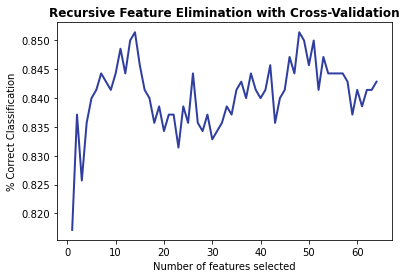

In [16]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure()
plt.title('Recursive Feature Elimination with Cross-Validation', fontweight='bold')
plt.xlabel('Number of features selected')
plt.ylabel('% Correct Classification')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=2)

# plt.xlim(0,10)
plt.show()


## model

In [3]:
fates = list(set(planets['fate']))

types = {fates[i] : i for i in range(len(fates))}

classes = []

for i in range(len(planets['fate'])):
    if planets['fate'][i] == "remaining":
        classes += [0]
    else:
        classes += [1]
        
classes = np.array(classes)

In [88]:
features_train, features_test, classes_train, classes_test = train_test_split(planets, classes, test_size=0.3, random_state=183)

ru = features_test['run'].to_numpy()
p = features_test['planet'].to_numpy()
et = features_test['end time'].to_numpy()
fa = features_test['fate'].to_numpy()

ru2 = features_train['run'].to_numpy()
p2 = features_train['planet'].to_numpy()
et2 = features_train['end time'].to_numpy()
fa2 = features_train['fate'].to_numpy()


d = ['run', 'planet', 'cv e', 'cv a', 'initial e',
       'final e', 'mean e', 'initial i', 'final i',
       'mean i', 'min i', 'max i', 'initial pericenter',
       'final pericenter', 'mean pericenter', 'min pericenter',
       'max pericenter', 'sd pericenter', 'initial jacobi', 'final jacobi',
       'mean jacobi', 'min jacobi', 'max jacobi', 'sd jacobi', 'initial mhr1',
       'final mhr1', 'mean mhr1', 'min mhr1',
       'initial mhr2', 'final mhr2', 'mean mhr2', 'min mhr2', 'max mhr2',
       'initial log a1_ratio', 'final log a1_ratio',
       'max log a1_ratio', 'initial log a2_ratio', 'final log a2_ratio',
       'mean log a2_ratio', 'min log a2_ratio', 'max log a2_ratio',
       'sd log a2_ratio', 'final log mass1_ratio',
       'mean log mass1_ratio', 'min log mass1_ratio', 'max log mass1_ratio',
       'sd log mass1_ratio','final log mass2_ratio', 'mean log mass2_ratio', 
       'min log mass2_ratio', 'max log mass2_ratio', 'sd log mass2_ratio', 
       'end time', 'fate']


# d = ['run', 'planet', 'cv e', 'cv a', 'initial e',
#        'final e', 'mean e', 'initial i', 'final i',
#        'mean i', 'min i', 'max i', 'initial pericenter',
#        'final pericenter', 'mean pericenter', 'min pericenter',
#        'max pericenter', 'sd pericenter', 'initial jacobi', 'final jacobi',
#        'mean jacobi', 'min jacobi', 'max jacobi', 'sd jacobi', 'initial mhr1',
#        'final mhr1', 'mean mhr1', 'min mhr1',
#        'initial mhr2', 'final mhr2', 'mean mhr2', 'min mhr2', 'max mhr2',
#        'initial log a1_ratio', 'final log a1_ratio', 'sd mhr2',
#        'max log a1_ratio', 'initial log a2_ratio', 'final log a2_ratio',
#        'mean log a2_ratio', 'min log a2_ratio', 'max log a2_ratio',
#        'sd log a2_ratio', 'final log mass1_ratio', 'max mhr1', 'sd mhr1',
#        'mean log mass1_ratio', 'min log mass1_ratio', 'max log mass1_ratio',
#        'sd log mass1_ratio','final log mass2_ratio', 'mean log mass2_ratio', 
#        'min log mass2_ratio', 'max log mass2_ratio', 'sd log mass2_ratio', 
#        'end time', 'fate']
            
      
ids_train = features_train['planet'].to_numpy()
features_train.drop(d, axis=1, inplace=True)

cols = features_train.columns
features_train = features_train.to_numpy()

ids_test = features_test['planet'].to_numpy()
features_test.drop(d, axis=1, inplace=True)
features_test = features_test.to_numpy()

/Users/neha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## basic classifier metrics

In [89]:
classifier = GradientBoostingClassifier(learning_rate = 0.07, max_depth = 5, max_features = 'sqrt', n_estimators = 150, random_state = 183) # ne = 120-160ish

classifier.fit(features_train, classes_train)

score = classifier.decision_function(features_test)
classes_predict = classifier.predict(features_test)
print('classifier is ', accuracy_score(classes_test, classes_predict) * 100, '% accurate on testing set' )

classifier is  91.33333333333333 % accurate on testing set


In [90]:
feats = classifier.feature_importances_
inds = np.argsort(feats)[::-1]

for i in range(len(inds)):
    print(cols[inds[i]], feats[inds[i]])

initial log mass1_ratio 0.2284446803320713
initial log mass2_ratio 0.15088461359369607
sd e 0.08882970673938431
sd i 0.0887333110315868
cv peri 0.08788828923842762
max e 0.056536410349581685
max mhr1 0.052032644413516176
sd mhr1 0.04385241518393655
sd mhr2 0.03881786276009931
sd log a1_ratio 0.03673711156689151
cv i 0.03322995359115643
min log a1_ratio 0.0331492314471055
mean log a1_ratio 0.03132540048841154
min e 0.029538369264135205


In [91]:
print(metrics.classification_report(classes_test, classes_predict, digits=3))

              precision    recall  f1-score   support

           0      0.882     0.769     0.822        78
           1      0.922     0.964     0.943       222

    accuracy                          0.913       300
   macro avg      0.902     0.867     0.882       300
weighted avg      0.912     0.913     0.911       300



In [77]:
print(recall_score(classes_test, classes_predict))

0.963963963963964


<Figure size 1080x504 with 0 Axes>

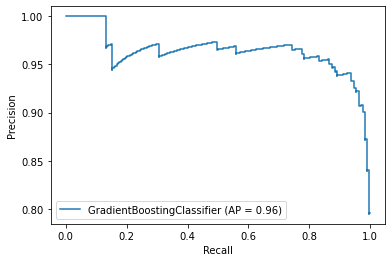

In [70]:
f=plt.figure(figsize=(15,7))

plot_precision_recall_curve(classifier, features_test, classes_test)

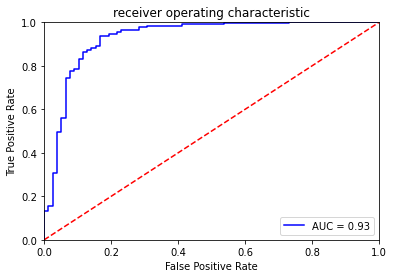

In [71]:
probs = classifier.predict_proba(features_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(classes_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('receiver operating characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1.0, 'misclassified planets - true classifications')

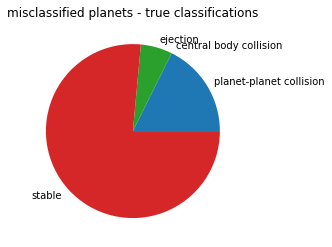

In [72]:
pp = 0
cb = 0
ej = 0
st = 0

for i in range(len(classes_test)):
    if (classes_test[i] != classes_predict[i]):
        if (fa[i] == 'planet-planet collision'):
            pp += 1
        if (fa[i] == 'ejected'):
            ej += 1
        if (fa[i] == 'central body collision'):
            cb += 1
        else:
            st += 1
            
            
nums = [pp, cb, ej, st]
labels = ['planet-planet collision', 'central body collision', 'ejection', 'stable']


plt.pie(nums, labels=labels)
plt.title('misclassified planets - true classifications')

## probabilities

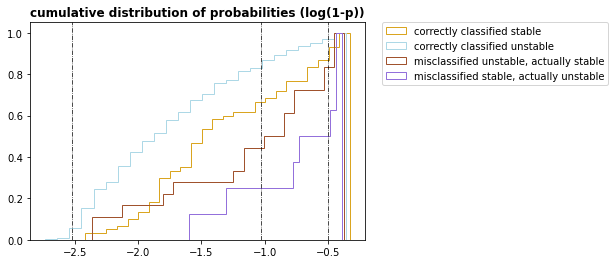

In [68]:
fig = plt.figure()
plt.title('cumulative distribution of probabilities (log(1-p))', fontweight='bold')

p = []
r = classifier.predict_proba(features_test)

for i in range(0,len(r)):
    if (classes_test[i] == classes_predict[i]):
        if (classes_test[i] == 0):
            p.append(np.log(1-r[i][0]))
        else:
            p.append(np.log(1-r[i][1]))
    else:
        if (classes_test[i] == 0):
            p.append(np.log10(1-r[i][1]))
        else:
            p.append(np.log10(1-r[i][0]))
              

                
cs = []
cu = []
ts = []   # misclassified unstable, actually stable
tu = []   # misclassified stable, actually unstable


# correct
inds = []

for i in range(0,len(classes_test)):
    if (classes_test[i] == classes_predict[i]):   # 0 = stable, 1 = unstable
        inds.append(i)

for i in range(0,len(r)):
    if (classes_test[i] == classes_predict[i]):
        if (classes_test[i] == 0):
            cs.append(np.log10(1-r[i][0]))
        else:
            cu.append(np.log10(1-r[i][1]))
            
            
# wrong
inds2 = []

for i in range(0,len(classes_test)):
    if (classes_test[i] != classes_predict[i]):
        inds2.append(i)

for i in range(0,len(r)):
    if (classes_test[i] != classes_predict[i]):
        if (classes_test[i] == 0):
            ts.append(np.log10(1-r[i][1]))
        else:
            tu.append(np.log10(1-r[i][0]))
                
                
                
n, bins, patches = plt.hist(cs, 25, density=True, histtype='step', cumulative=True, label='correctly classified stable', color='goldenrod')
n, bins, patches = plt.hist(cu, 25, density=True, histtype='step', cumulative=True, label='correctly classified unstable', color='lightblue')
n, bins, patches = plt.hist(ts, 25, density=True, histtype='step', cumulative=True, label='misclassified unstable, actually stable', color='sienna')
n, bins, patches = plt.hist(tu, 25, density=True, histtype='step', cumulative=True, label='misclassified stable, actually unstable', color='mediumpurple')
# n, bins, patches = plt.hist(p, 25, density=True, histtype='step', cumulative=True, label='all', color='black', linewidth=1.25)



# sigmas, log10(1-0.68) = -0.495, log10(1-0.95) = -1.031, log10(1-0.997) = -2.523
plt.axvline(x=-0.495, color='black', linestyle='-.', linewidth=0.7)
plt.axvline(x=-1.031, color='black', linestyle='-.', linewidth=0.7)
plt.axvline(x=-2.523, color='black', linestyle='-.', linewidth=0.7)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

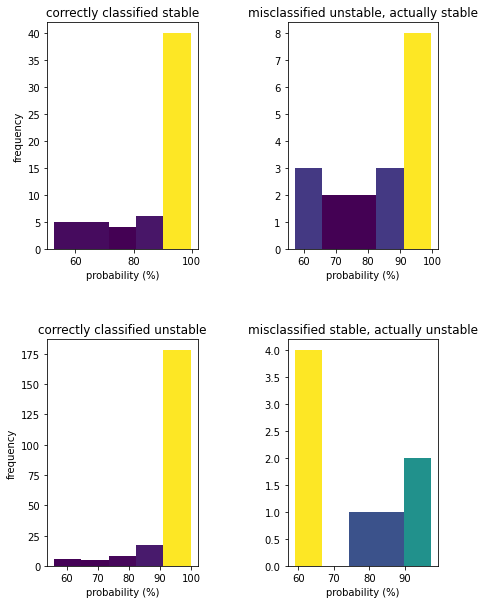

In [78]:
# histogram

%matplotlib inline

fig = plt.figure(figsize=(7, 10))
# plt.suptitle('distribution of probabilities', y=1.04, fontweight='bold')
    
    

cs = []
cu = []
ts = []   # misclassified unstable, actually stable
tu = []   # misclassified stable, actually unstable


# correct
inds = []

for i in range(0,len(classes_test)):
    if (classes_test[i] == classes_predict[i]):   # 0 = stable, 1 = unstable
        inds.append(i)

r = classifier.predict_proba(features_test)

for i in range(0,len(r)):
    if (classes_test[i] == classes_predict[i]):
        if (classes_test[i] == 0):
            cs.append(r[i][0]*100)
        else:
            cu.append(r[i][1]*100)
            
            
# wrong
inds2 = []

r2 = classifier.predict_proba(features_test)

for i in range(0,len(classes_test)):
    if (classes_test[i] != classes_predict[i]):
        inds2.append(i)

for i in range(0,len(r2)):
    if (classes_test[i] != classes_predict[i]):
        if (classes_test[i] == 0):
            ts.append(r2[i][1]*100)
        else:
            tu.append(r2[i][0]*100)
            
            
plt.subplot(2, 2, 1)
N, bins, patches = plt.hist(cs, bins = 5)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('probability (%)')
plt.title('correctly classified stable')
plt.ylabel('frequency')


plt.subplot(2, 2, 2)
N, bins, patches = plt.hist(ts, bins = 5)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('probability (%)')
plt.title('misclassified unstable, actually stable')


plt.subplot(2, 2, 3)
N, bins, patches = plt.hist(cu, bins = 5)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('probability (%)')
plt.title('correctly classified unstable')
plt.ylabel('frequency')


plt.subplot(2, 2, 4)
N, bins, patches = plt.hist(tu, bins = 5)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('probability (%)')
plt.title('misclassified stable, actually unstable')


plt.subplots_adjust(wspace=0.6, hspace = 0.4)
plt.show()

## classification tree

[Text(3337.376958863859, 1057.0, 'X[12] <= -0.015\ngini = 0.418\nsamples = 700\nvalue = [208, 492]'),
 Text(1684.9987757100882, 996.6, 'X[4] <= 0.003\ngini = 0.272\nsamples = 549\nvalue = [89, 460]'),
 Text(792.4583741429971, 936.2, 'X[13] <= -1.218\ngini = 0.5\nsamples = 113\nvalue = [55, 58]'),
 Text(174.8873653281097, 875.8, 'X[8] <= 0.577\ngini = 0.293\nsamples = 28\nvalue = [5, 23]'),
 Text(87.44368266405485, 815.4000000000001, 'gini = 0.0\nsamples = 19\nvalue = [0, 19]'),
 Text(262.33104799216454, 815.4000000000001, 'X[9] <= 0.538\ngini = 0.494\nsamples = 9\nvalue = [5, 4]'),
 Text(174.8873653281097, 755.0, 'X[5] <= 0.112\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(87.44368266405485, 694.6, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(262.33104799216454, 694.6, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(349.7747306562194, 755.0, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(1410.0293829578843, 875.8, 'X[0] <= 0.001\ngini = 0.484\nsamples = 85\nvalue = [50, 

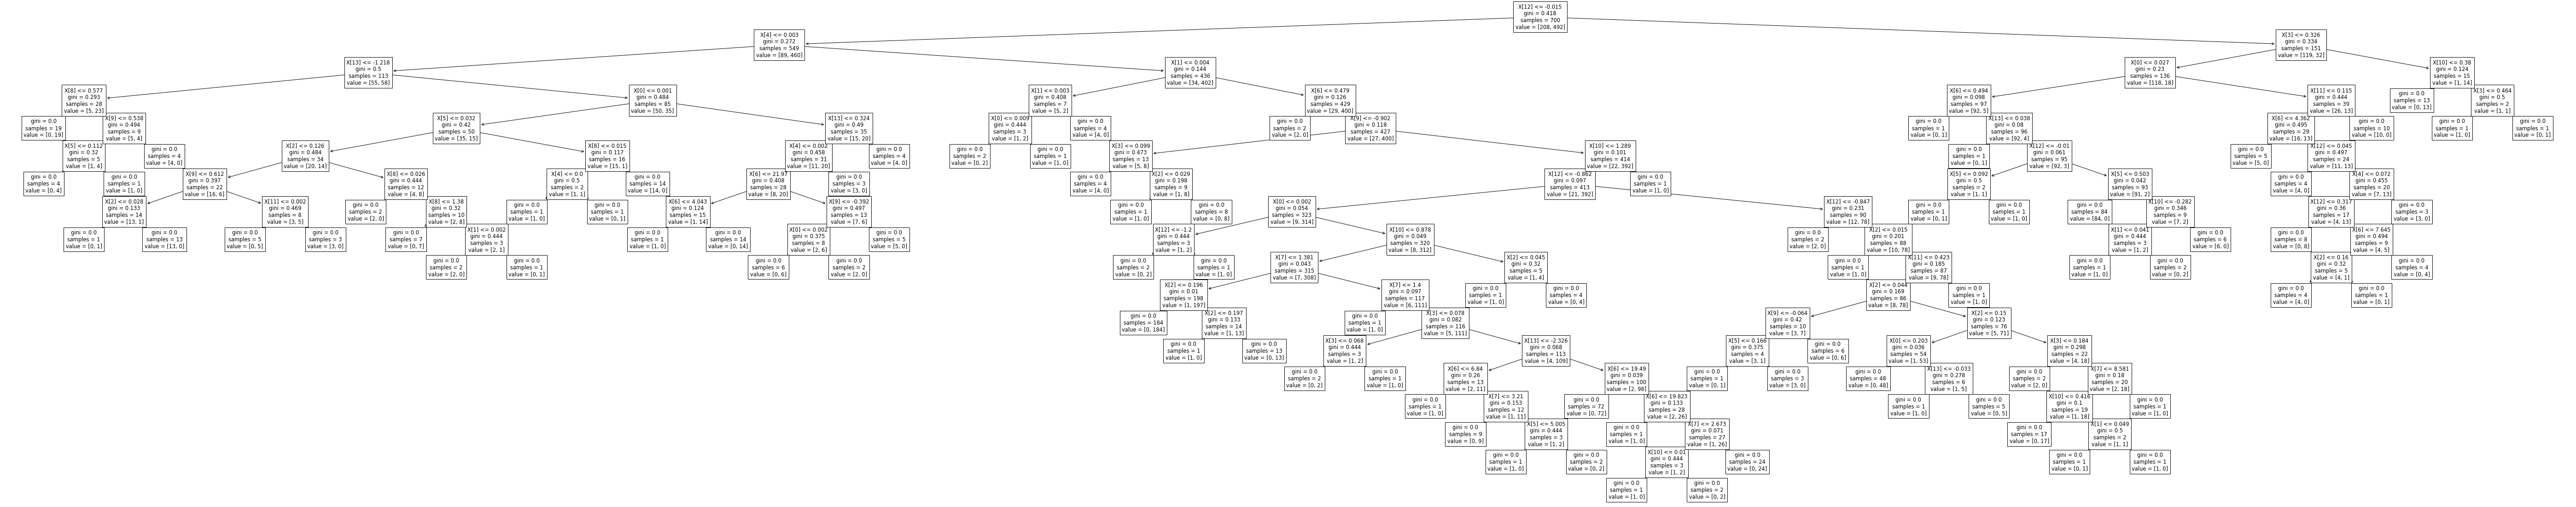

In [80]:
X, y = features_train, classes_train

c = GradientBoostingClassifier(random_state=1)
c.fit(X, y)

c = DecisionTreeClassifier(random_state=1)

f = plt.figure(figsize=(100,20))
tree.plot_tree(c.fit(X, y))
# plt.savefig('10mm 2-3 tree')

In [81]:
X, y = features_train, classes_train

clf = GradientBoostingClassifier(random_state=1)
clf.fit(X, y)

pdf = FPDF()

imagelist=[]

for i in range(0,len(clf.estimators_)):    
    t = clf.estimators_[i, 0]

    dot_data = export_graphviz(
        t,
        out_file=None, filled=True, rounded=True,
        special_characters=True,
        proportion=False, impurity=False, class_names = True,
    )

    # class_names = True, feature_names=[insert list of feature names]
    
    
    n = str(i) + '.png'
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.set_size('6.5, 6.5!')
    pydot_graph.write_png(n)
    
#     picture= Image.open(n)
#     picture.rotate(270).save(n)
    
    imagelist.append(n)
    


for image in imagelist:
    pdf.add_page()
    pdf.image(image)
    
pdf.output("10mm 2-3 gb tree.pdf", "F")

''

## corner plot

In [83]:
m1ratio = []
m2ratio = []
sde = []
sdi = []
cvperi = []


m1ratio_sc = []       # stable correct
m2ratio_sc = []
sde_sc = []
cvperi_sc = []
sdi_sc = []
 
m1ratio_uc = []       # unstable correct
m2ratio_uc = []
sde_uc = []
cvperi_uc = []
sdi_uc = []

m1ratio_ts = []       # misclassified unstable, true stable
m2ratio_ts = []
sde_ts = []
cvperi_ts = []
sdi_ts = []

m1ratio_tu = []       # misclassified stable, true unstable
m2ratio_tu = []
sde_tu = []
cvperi_tu = []
sdi_tu = []



ind = []


for c in range(len(features_test)):
    if (np.isnan(np.log10(features_test[c].any()))):
        pass
    
    if (np.log10(features_test[c].all()) != math.inf):
        if ((np.log10(features_test[c].all()) != -math.inf)):
            ind.append(c)

            
# sd e = [4]
# sd i = [5]
# cv peri = [0]
# log mass 1 ratio = [12]
# log mass 2 ratio = [13]



for i in range(len(ind)):
    m1ratio.append(features_test[ind[i]][12])
    m2ratio.append(features_test[ind[i]][13])
    sde.append(np.log10(features_test[ind[i]][4]))
    cvperi.append(np.log10(features_test[ind[i]][0]))
    sdi.append(np.log10(features_test[ind[i]][5]))
        
    if (classes_test[ind[i]] == classes_predict[ind[i]]):
        if (classes_test[ind[i]] == 0):
            m1ratio_sc.append(features_test[ind[i]][12])
            m2ratio_sc.append(features_test[ind[i]][13])
            sde_sc.append(np.log10(features_test[ind[i]][4]))
            cvperi_sc.append(np.log10(features_test[ind[i]][0]))
            sdi_sc.append(np.log10(features_test[ind[i]][5]))
        elif (classes_test[ind[i]] == 1):
            m1ratio_uc.append(features_test[ind[i]][12])
            m2ratio_uc.append(features_test[ind[i]][13])
            sde_uc.append(np.log10(features_test[ind[i]][4]))
            cvperi_uc.append(np.log10(features_test[ind[i]][0]))
            sdi_uc.append(np.log10(features_test[ind[i]][5]))
    else:
        if (classes_test[ind[i]] == 0 and classes_predict[ind[i]] == 1):
            m1ratio_ts.append(features_test[ind[i]][12])
            m2ratio_ts.append(features_test[ind[i]][13])
            sde_ts.append(np.log10(features_test[ind[i]][4]))
            cvperi_ts.append(np.log10(features_test[ind[i]][0]))
            sdi_ts.append(np.log10(features_test[ind[i]][5]))
        elif (classes_test[ind[i]] == 1 and classes_predict[ind[i]] == 0):
            m1ratio_tu.append(features_test[ind[i]][12])
            m2ratio_tu.append(features_test[ind[i]][13])
            sde_tu.append(np.log10(features_test[ind[i]][4]))
            cvperi_tu.append(np.log10(features_test[ind[i]][0]))
            sdi_tu.append(np.log10(features_test[ind[i]][5]))   

<ipython-input-83-ec6ebd38f267>:41: RuntimeWarning: divide by zero encountered in log10
  if (np.log10(features_test[c].all()) != math.inf):
<ipython-input-83-ec6ebd38f267>:42: RuntimeWarning: divide by zero encountered in log10
  if ((np.log10(features_test[c].all()) != -math.inf)):


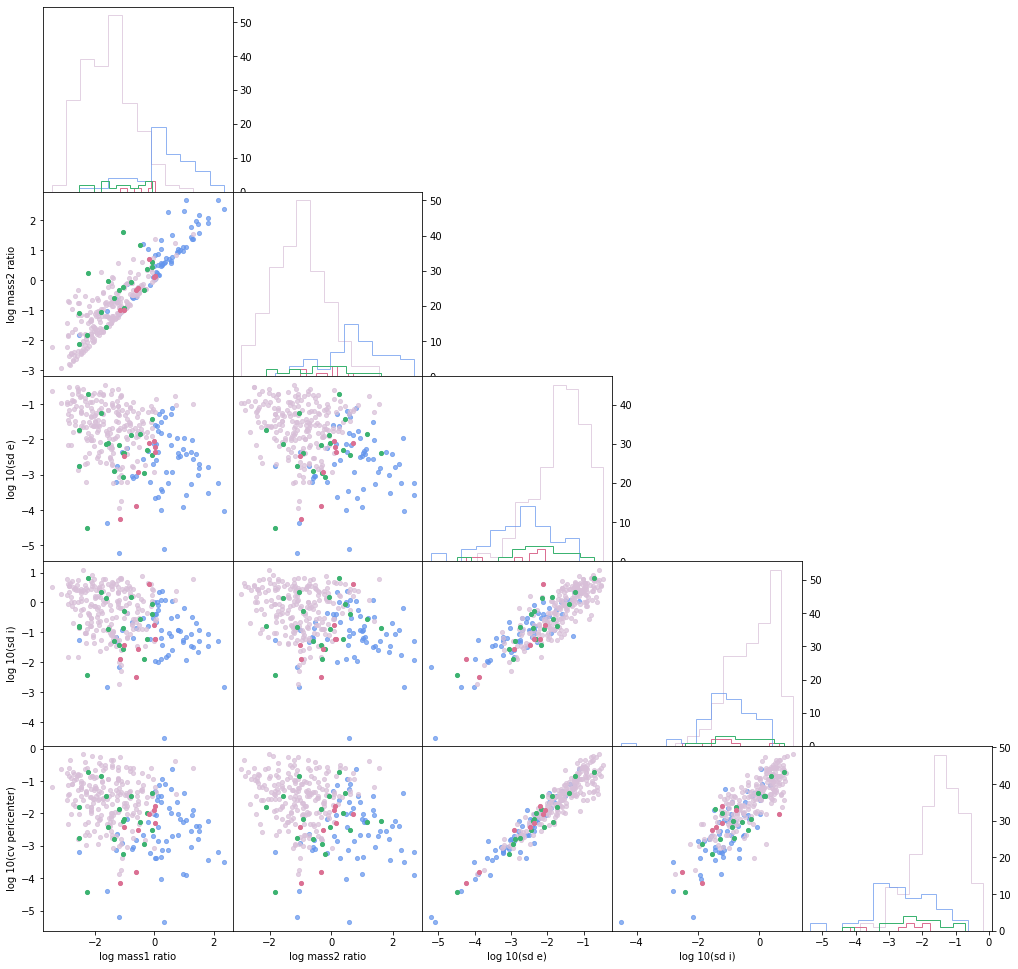

In [84]:
%matplotlib inline

fig, axs = plt.subplots(5,5, figsize=(17,17))#, sharex="col") # sharey = 'row')

var = [m1ratio, m2ratio, sde, sdi, cvperi]
varsc = [m1ratio_sc, m2ratio_sc, sde_sc, sdi_sc, cvperi_sc]
varuc = [m1ratio_uc, m2ratio_uc, sde_uc, sdi_uc, cvperi_uc]
varts = [m1ratio_ts, m2ratio_ts, sde_ts, sdi_ts, cvperi_ts]
vartu = [m1ratio_tu, m2ratio_tu, sde_tu, sdi_tu, cvperi_tu]

ns = ['log mass1 ratio', 'log mass2 ratio', 'log 10(sd e)', 'log 10(sd i)', 'log 10(cv pericenter)']


for x in range(0,5):
    for y in range(0,5):
        
        if (y > x):
            axs[x,y].set_visible(False)
        
        elif (y == x):           
    
            axs[x,y].yaxis.tick_right()            
        
            axs[x,y].hist(varuc[x], histtype='step', color='thistle', alpha=0.7)
            axs[x,y].hist(vartu[x], histtype='step', color='palevioletred')
            axs[x,y].hist(varsc[x], histtype='step', color='cornflowerblue', alpha=0.7)
            axs[x,y].hist(varts[x], histtype='step', color='mediumseagreen')
        
        else:
            axs[x,y].scatter(varsc[y], varsc[x], 17, color = 'cornflowerblue', label = "correcly classified stable", alpha=0.7) 
            axs[x,y].scatter(varts[y], varts[x], 17, color = 'mediumseagreen', label = "misclassified unstable, actually stable", zorder = 2) 
            axs[x,y].scatter(varuc[y], varuc[x], 17, color = 'thistle', label = "correctly classified unstable", alpha=0.7)
            axs[x,y].scatter(vartu[y], vartu[x], 17, color = 'palevioletred', label = "misclassified stable, actually unstable", zorder = 2)
            
            if (y == 0):
                axs[x,y].set_ylabel(str(ns[x]))
            else:
                axs[x,y].set_yticks([])
            
            if (x == 4):
                axs[x,y].set_xlabel(str(ns[y]))
            else:
                axs[x,y].set_xticks([])


                  
plt.subplots_adjust(wspace=0, hspace=0)

## mass

In [7]:
data = dict()

for rn in range(1,101):
    data[rn] = dict()
    
    for planetnum in range(1,11):
        data[rn][planetnum] = dict()
        pl = genfromtxt(r'/Users/neha/Documents/lanl/classifier/s. mordasini data/run'+str(rn)+'/PL'+str(planetnum)+'.el',skip_header=2, max_rows=1)
        
        data[rn][planetnum]['mass'] = pl[1]

In [22]:
pred = cross_val_predict(classifier, features_train, classes_train, cv=10)

fate = []

for i in range(len(fa)):
    if (fa[i] == 'remaining'):
        fate.append(0)
    else:
        fate.append(1)
        
        
        
test_tup = [(ru[i], p[i]) for i in range (len(ru))]
all_dict = {}
for i in range(len(ru)):
    tt = test_tup[i]
    all_dict[tt] = {}
    all_dict[tt]['outcome'] = classes_test[i]
    all_dict[tt]['predict'] = classes_predict[i]
    all_dict[tt]['end time'] = et[i]
    all_dict[tt]['type'] = 'test'
    
    
test_tup = [(ru2[i], p2[i]) for i in range (len(ru2))]    
for i in range(len(ru2)):
    tt = test_tup[i]
    all_dict[tt] = {}
    all_dict[tt]['outcome'] = classes_train[i]
    all_dict[tt]['predict'] = pred[i]
    all_dict[tt]['end time'] = et2[i]
    all_dict[tt]['type'] = 'train'

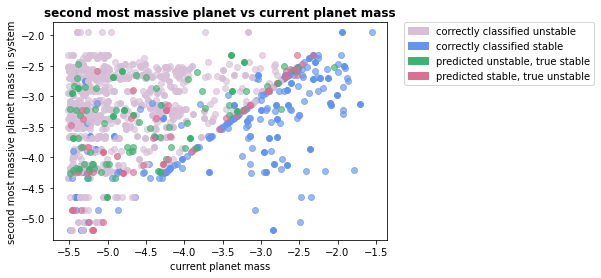

In [9]:
fig = plt.figure()
plt.title('second most massive planet vs current planet mass', fontweight='bold')


for rn in range(1,101):
    ms = []
    
    for p in range(1,11):
        ms.append(data[rn][p]['mass'])
    
    m1 = np.max(ms) 
    ms.remove(m1)
    m2 = np.max(ms)
    
    for p in range(1,11):
        col = 'white'
        zord = 1
        alp = 1

        if (all_dict[rn, p]['outcome'] == all_dict[rn, p]['predict']):
            if (all_dict[rn, p]['outcome'] == 1): # unstable
                col = 'thistle'
            else:
                col = 'cornflowerblue'
        else:
            zord = 3
            if (all_dict[rn, p]['outcome'] == 1): # true unstable, predicted stable
                col = 'palevioletred'
            else:
                col = 'mediumseagreen'
                    
        if (all_dict[rn, p]['type'] == 'train'):
            alp = 0.65
                
        plt.scatter(np.log10(data[rn][p]['mass']), np.log10(m2), color = col, zorder = zord, alpha = alp)
          
        
plt.xlabel('current planet mass')
plt.ylabel('second most massive planet mass in system')

patch = mpatches.Patch(color='mediumseagreen', label='predicted unstable, true stable')
patch2 = mpatches.Patch(color='cornflowerblue', label='correctly classified stable')
patch3 = mpatches.Patch(color='palevioletred', label='predicted stable, true unstable')
patch4 = mpatches.Patch(color='thistle', label='correctly classified unstable')

plt.legend(handles=[patch4, patch2, patch, patch3], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  

# plt.ylim(-5.5, -1)

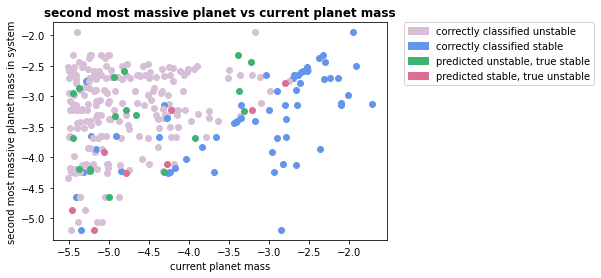

In [10]:
fig = plt.figure()
plt.title('second most massive planet vs current planet mass', fontweight='bold')


for rn in range(1,101):
    ms = []
    
    for p in range(1,11):
        ms.append(data[rn][p]['mass'])
    
    m1 = np.max(ms) 
    ms.remove(m1)
    m2 = np.max(ms)
    
    for p in range(1,11):
        col = 'white'
        zord = 1
        alp = 1

        if (all_dict[rn, p]['type'] == 'train'):
            pass
        
        else:
            if (all_dict[rn, p]['outcome'] == all_dict[rn, p]['predict']):
                if (all_dict[rn, p]['outcome'] == 1): # unstable
                    col = 'thistle'
                else:
                    col = 'cornflowerblue'
            else:
                zord = 3
                if (all_dict[rn, p]['outcome'] == 1): # true unstable, predicted stable
                    col = 'palevioletred'
                else:
                    col = 'mediumseagreen'

            plt.scatter(np.log10(data[rn][p]['mass']), np.log10(m2), color = col, zorder = zord, alpha = alp)
          
        
plt.xlabel('current planet mass')
plt.ylabel('second most massive planet mass in system')

patch = mpatches.Patch(color='mediumseagreen', label='predicted unstable, true stable')
patch2 = mpatches.Patch(color='cornflowerblue', label='correctly classified stable')
patch3 = mpatches.Patch(color='palevioletred', label='predicted stable, true unstable')
patch4 = mpatches.Patch(color='thistle', label='correctly classified unstable')

plt.legend(handles=[patch4, patch2, patch, patch3], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  

# plt.ylim(-5.5, -1)

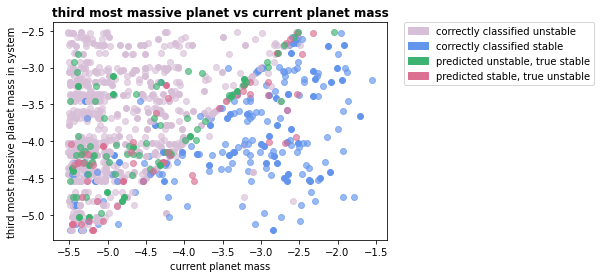

In [11]:
fig = plt.figure()
plt.title('third most massive planet vs current planet mass', fontweight='bold')


for rn in range(1,101):
    ms = []
    
    for p in range(1,11):
        ms.append(data[rn][p]['mass'])
    
    m1 = np.max(ms) 
    ms.remove(m1)
    m2 = np.max(ms)
    ms.remove(m2)
    m3 = np.max(ms)
    
    for p in range(1,11):
        col = 'white'
        zord = 1
        alp = 1

        if (all_dict[rn, p]['outcome'] == all_dict[rn, p]['predict']):
            if (all_dict[rn, p]['outcome'] == 1): # unstable
                col = 'thistle'
            else:
                col = 'cornflowerblue'
        else:
            zord = 3
            if (all_dict[rn, p]['outcome'] == 1): # true unstable, predicted stable
                col = 'palevioletred'
            else:
                col = 'mediumseagreen'
                    
        if (all_dict[rn, p]['type'] == 'train'):
            alp = 0.65
                
        plt.scatter(np.log10(data[rn][p]['mass']), np.log10(m3), color = col, zorder = zord, alpha = alp)
          
        
plt.xlabel('current planet mass')
plt.ylabel('third most massive planet mass in system')

patch = mpatches.Patch(color='mediumseagreen', label='predicted unstable, true stable')
patch2 = mpatches.Patch(color='cornflowerblue', label='correctly classified stable')
patch3 = mpatches.Patch(color='palevioletred', label='predicted stable, true unstable')
patch4 = mpatches.Patch(color='thistle', label='correctly classified unstable')

plt.legend(handles=[patch4, patch2, patch, patch3], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  

# plt.ylim(-5.5, -1)

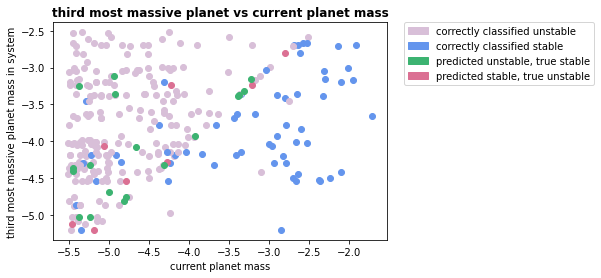

In [12]:
fig = plt.figure()
plt.title('third most massive planet vs current planet mass', fontweight='bold')


for rn in range(1,101):
    ms = []
    
    for p in range(1,11):
        ms.append(data[rn][p]['mass'])
    
    m1 = np.max(ms) 
    ms.remove(m1)
    m2 = np.max(ms)
    ms.remove(m2)
    m3 = np.max(ms)
    
    for p in range(1,11):
        col = 'white'
        zord = 1
        alp = 1

        if (all_dict[rn, p]['type'] == 'train'):
            pass
        
        else:
            if (all_dict[rn, p]['outcome'] == all_dict[rn, p]['predict']):
                if (all_dict[rn, p]['outcome'] == 1): # unstable
                    col = 'thistle'
                else:
                    col = 'cornflowerblue'
            else:
                zord = 3
                if (all_dict[rn, p]['outcome'] == 1): # true unstable, predicted stable
                    col = 'palevioletred'
                else:
                    col = 'mediumseagreen'
                    
            plt.scatter(np.log10(data[rn][p]['mass']), np.log10(m3), color = col, zorder = zord, alpha = alp)
          
        
plt.xlabel('current planet mass')
plt.ylabel('third most massive planet mass in system')

patch = mpatches.Patch(color='mediumseagreen', label='predicted unstable, true stable')
patch2 = mpatches.Patch(color='cornflowerblue', label='correctly classified stable')
patch3 = mpatches.Patch(color='palevioletred', label='predicted stable, true unstable')
patch4 = mpatches.Patch(color='thistle', label='correctly classified unstable')

plt.legend(handles=[patch4, patch2, patch, patch3], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  

# plt.ylim(-5.5, -1)

## misclassifications

#### misclassified unstable, true stable

Text(0.5, 1.0, 'Misclassifed unstable, true stable \nplanets by system location')

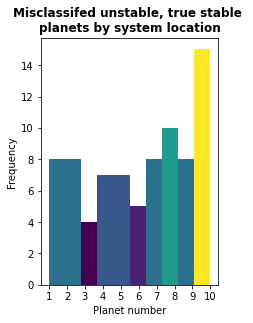

In [97]:
plnumberg = []

for rn in range(1,101):
    for p in range(1,11):
        if (all_dict[rn, p]['outcome'] == 0) and (all_dict[rn, p]['predict'] == 1):
            plnumberg.append(p)
            

            
fig = plt.figure(figsize=(7, 10))            
            
plt.subplot(2, 2, 1)
N, bins, patches = plt.hist(plnumberg, bins = 10)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('Planet number')
plt.xticks(range(1, 11))
plt.ylabel('Frequency')
plt.title('Misclassifed unstable, true stable \nplanets by system location', loc='center', fontweight='bold')

Text(0, 0.5, 'final system multiplicity')

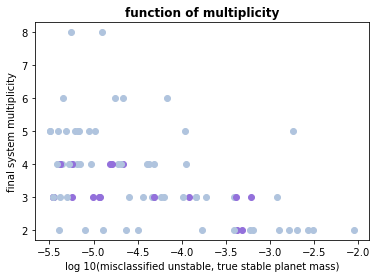

In [95]:
fig = plt.figure()
plt.title('function of multiplicity', fontweight='bold')

col = 'white'

for rn in range(1,101):
    for p in range(1,11):
        multcount = 0
        if (all_dict[rn, p]['outcome'] == 0) and (all_dict[rn, p]['predict'] == 1):
            for p2 in range(1,11):
                if (all_dict[rn, p2]['outcome'] == 0):
                    multcount += 1
                    
            if (all_dict[rn, p]['type'] == 'test'):
                col = 'mediumpurple'
            else:
                col = 'lightsteelblue'
                
            plt.scatter(np.log10(data[rn][p]['mass']), multcount, color = col)
            
            
plt.xlabel('log 10(misclassified unstable, true stable planet mass)')
plt.ylabel('final system multiplicity')

Text(0, 0.5, 'log 10(most massive planet in system)')

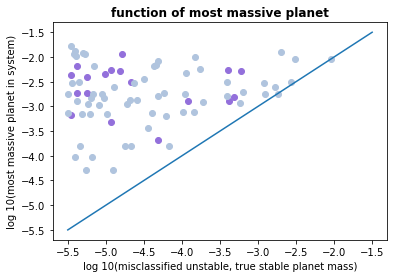

In [94]:
fig = plt.figure()
plt.title('function of most massive planet', fontweight='bold')

col = 'white'

for rn in range(1,101):
    for p in range(1,11):
        allms = []
        if (all_dict[rn, p]['outcome'] == 0) and (all_dict[rn, p]['predict'] == 1):
            for p2 in range(1,11):
                allms.append(data[rn][p2]['mass'])
            
            mm1 = np.max(allms)
            
            if (all_dict[rn, p]['type'] == 'test'):
                col = 'mediumpurple'
            else:
                col = 'lightsteelblue'
                
            plt.scatter(np.log10(data[rn][p]['mass']), np.log10(mm1), color = col)
        

plt.plot([-5.5, -1.5], [-5.5, -1.5])
plt.xlabel('log 10(misclassified unstable, true stable planet mass)')
plt.ylabel('log 10(most massive planet in system)')

In [101]:
redms = []
stms = []
unstms = []

for rn in range(1,101):
    for p in range(1,11):
        if (all_dict[rn, p]['outcome'] == 0) and (all_dict[rn, p]['predict'] == 1):
            redms.append(np.log10(data[rn][p]['mass']))
            
        if (all_dict[rn, p]['outcome'] == 0):
            stms.append(np.log10(data[rn][p]['mass']))
            
        if (all_dict[rn, p]['outcome'] == 1):
            unstms.append(np.log10(data[rn][p]['mass']))
            

print('misclassified unstable, true stable planets')
# print('average: ', np.average(redms))
print('median: ', np.median(redms))
print('\n correctly classified unstable')
# print('average: ', np.average(unstms))
print('median: ', np.median(unstms))
print('\n correctly classified stable')
# print('average: ', np.average(stms))
print('median: ', np.median(stms))

misclassified unstable, true stable planets
median:  -4.701381111163373

 correctly classified unstable
median:  -5.063819193770474

 correctly classified stable
median:  -3.3764982832477295


In [95]:
gcount = 0
innermm = 0
outermm = 0
twomm = 0
nomm = 0

for rn in range(1,101):
    for p in range(1,11):
        if (all_dict[rn, p]['outcome'] == 0) and (all_dict[rn, p]['predict'] == 1): #and (all_dict[rn, p]['type'] == 'test'):
            gcount += 1
            cm = data[rn][p]['mass']
            
            if (p == 1):
                mi = data[rn][2]['mass']; mo = data[rn][3]['mass']
            elif (p == 10):
                mi = data[rn][9]['mass']; mo = data[rn][8]['mass']
            else:
                mi = data[rn][p-1]['mass']; mo = data[rn][p+1]['mass']
                
            if (mi > cm) and (mo > cm):
                twomm += 1     
            elif (mi > cm):
                innermm += 1
            elif (mo > cm):
                outermm += 1
            else:
                nomm += 1
            
                
print('number of planets misclassified unstable, true stable: ', gcount)
print('planets with two more massive neighboring planets: ', twomm)
print('planets with one more massive neighboring planet: ', innermm + outermm)
print('\tmore massive inner neighboring planet: ', innermm)
print('\tmore massive outer neighboring planet: ', outermm)
print('planets more massive than both neighboring planets: ', nomm)

number of planets misclassified unstable, true stable:  80
planets with two more massive neighboring planets:  24
planets with one more massive neighboring planet:  31
	more massive inner neighboring planet:  17
	more massive outer neighboring planet:  14
planets more massive than both neighboring planets:  25


In [96]:
gcount = 0
boths = 0
outers = 0
inners = 0
nos = 0

for rn in range(1,101):
    for p in range(1,11):
        if (all_dict[rn, p]['outcome'] == 0) and (all_dict[rn, p]['predict'] == 1): #and (all_dict[rn, p]['type'] == 'test'):
            gcount += 1
            
            if (p == 1):
                mi = 2; mo = 3
            elif (p == 10):
                mi = 9; mo = 8
            else:
                mi = p-1; mo = p+1
                
            if (all_dict[rn, mi]['outcome'] == 0) and (all_dict[rn, mo]['outcome'] == 0):
                boths += 1
            elif (all_dict[rn, mi]['outcome'] == 0):
                inners += 1
            elif (all_dict[rn, mo]['outcome'] == 0):
                outers += 1
            else:
                nos += 1
                
                
print('number of planets misclassified unstable, true stable: ', gcount)
print('planets with two stable neighboring planets: ', boths)
print('planets with stable inner neighboring planet: ', inners)
print('planets with stable outer neighboring planet: ', outers)
print('planets more no stable neighboring planets: ', nos)

number of planets misclassified unstable, true stable:  80
planets with two stable neighboring planets:  6
planets with stable inner neighboring planet:  18
planets with stable outer neighboring planet:  17
planets more no stable neighboring planets:  39


#### misclassified stable, true unstable

Text(0.5, 1.0, 'Misclassifed stable, true unstable \nplanets by system location')

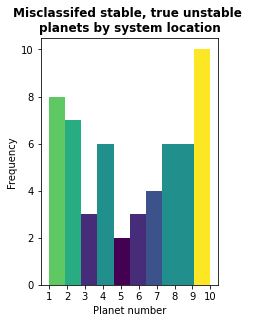

In [122]:
plnumberg = []

for rn in range(1,101):
    for p in range(1,11):
        if (all_dict[rn, p]['outcome'] == 1) and (all_dict[rn, p]['predict'] == 0):
            plnumberg.append(p)
            

            
fig = plt.figure(figsize=(7, 10))            
            
plt.subplot(2, 2, 1)
N, bins, patches = plt.hist(plnumberg, bins = 10)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('Planet number')
plt.xticks(range(1, 11))
plt.ylabel('Frequency')
plt.title('Misclassifed stable, true unstable \nplanets by system location', loc='center', fontweight='bold')

Text(0, 0.5, 'final system multiplicity')

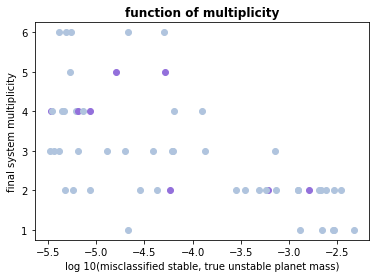

In [96]:
fig = plt.figure()
plt.title('function of multiplicity', fontweight='bold')

for rn in range(1,101):
    for p in range(1,11):
        multcount = 0
        if (all_dict[rn, p]['outcome'] == 1) and (all_dict[rn, p]['predict'] == 0):
            for p2 in range(1,11):
                if (all_dict[rn, p2]['outcome'] == 0):
                    multcount += 1
                    
            if (all_dict[rn, p]['type'] == 'test'):
                col = 'mediumpurple'
            else:
                col = 'lightsteelblue'
                
            plt.scatter(np.log10(data[rn][p]['mass']), multcount, color = col)
            
            
plt.xlabel('log 10(misclassified stable, true unstable planet mass)')
plt.ylabel('final system multiplicity')

Text(0, 0.5, 'log 10(end time)')

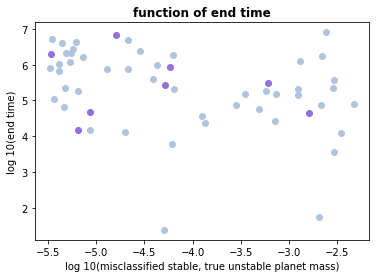

In [97]:
fig = plt.figure()
plt.title('function of end time', fontweight='bold')


for rn in range(1,101):
    for p in range(1,11):
        if (all_dict[rn, p]['outcome'] == 1) and (all_dict[rn, p]['predict'] == 0):
            if (all_dict[rn, p]['type'] == 'test'):
                col = 'mediumpurple'
            else:
                col = 'lightsteelblue'
            plt.scatter(np.log10(data[rn][p]['mass']), np.log10(all_dict[rn, p]['end time']), color = col)
            
            
plt.xlabel('log 10(misclassified stable, true unstable planet mass)')
plt.ylabel('log 10(end time)')

Text(0, 0.5, 'log 10(most massive planet in system)')

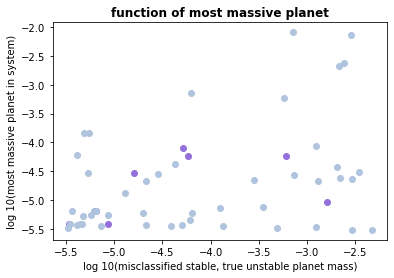

In [98]:
fig = plt.figure()
plt.title('function of most massive planet', fontweight='bold')


for rn in range(1,101):
    for p in range(1,11):
        allms = []
        if (all_dict[rn, p]['outcome'] == 1) and (all_dict[rn, p]['predict'] == 0):
            for p2 in range(1,11):
                allms.append(data[rn][p2]['mass'])
            
            mm1 = np.max(data[rn][p2]['mass'])
            
            if (all_dict[rn, p]['type'] == 'test'):
                col = 'mediumpurple'
            else:
                col = 'lightsteelblue'
            
            plt.scatter(np.log10(data[rn][p]['mass']), np.log10(mm1), color = col)
            
            
plt.xlabel('log 10(misclassified stable, true unstable planet mass)')
plt.ylabel('log 10(most massive planet in system)')

In [120]:
gcount = 0
innermm = 0
outermm = 0
twomm = 0
nomm = 0

for rn in range(1,101):
    for p in range(1,11):
        if (all_dict[rn, p]['outcome'] == 1) and (all_dict[rn, p]['predict'] == 0): #and (all_dict[rn, p]['type'] == 'test'):
            gcount += 1
            cm = data[rn][p]['mass']
            
            if (p == 1):
                mi = data[rn][2]['mass']; mo = data[rn][3]['mass']
            elif (p == 10):
                mi = data[rn][9]['mass']; mo = data[rn][8]['mass']
            else:
                mi = data[rn][p-1]['mass']; mo = data[rn][p+1]['mass']
                
            if (mi > cm) and (mo > cm):
                twomm += 1     
            elif (mi > cm):
                innermm += 1
            elif (mo > cm):
                outermm += 1
            else:
                nomm += 1
            
                
print('number of planets misclassified stable, true unstable: ', gcount)
print('planets with two more massive neighboring planets: ', twomm)
print('planets with one more massive neighboring planet: ', innermm + outermm)
print('\tmore massive inner neighboring planet: ', innermm)
print('\tmore massive outer neighboring planet: ', outermm)
print('planets more massive than both neighboring planets: ', nomm)

number of planets misclassified stable, true unstable:  55
planets with two more massive neighboring planets:  12
planets with one more massive neighboring planet:  18
	more massive inner neighboring planet:  9
	more massive outer neighboring planet:  9
planets more massive than both neighboring planets:  25


In [121]:
gcount = 0
boths = 0
outers = 0
inners = 0
nos = 0

for rn in range(1,101):
    for p in range(1,11):
        if (all_dict[rn, p]['outcome'] == 1) and (all_dict[rn, p]['predict'] == 0): #and (all_dict[rn, p]['type'] == 'test'):
            gcount += 1
            
            if (p == 1):
                mi = 2; mo = 3
            elif (p == 10):
                mi = 9; mo = 8
            else:
                mi = p-1; mo = p+1
                
            if (all_dict[rn, mi]['outcome'] == 0) and (all_dict[rn, mo]['outcome'] == 0):
                boths += 1
            elif (all_dict[rn, mi]['outcome'] == 0):
                inners += 1
            elif (all_dict[rn, mo]['outcome'] == 0):
                outers += 1
            else:
                nos += 1
                
                
print('number of planets misclassified stable, true unstable: ', gcount)
print('planets with two stable neighboring planets: ', boths)
print('planets with stable inner neighboring planet: ', inners)
print('planets with stable outer neighboring planet: ', outers)
print('planets more no stable neighboring planets: ', nos)

number of planets misclassified stable, true unstable:  55
planets with two stable neighboring planets:  5
planets with stable inner neighboring planet:  12
planets with stable outer neighboring planet:  12
planets more no stable neighboring planets:  26


<ipython-input-172-b2efcaef76f7>:12: UserWarning: genfromtxt: Empty input file: "/Users/neha/Documents/lanl/classifier/s. mordasini data/run11/PL4.el"
  pl2 = genfromtxt(r'/Users/neha/Documents/lanl/classifier/s. mordasini data/run'+str(rn)+'/PL'+str(planetnum)+'.el',skip_header=(le-1), max_rows=1)
<ipython-input-172-b2efcaef76f7>:12: UserWarning: genfromtxt: Empty input file: "/Users/neha/Documents/lanl/classifier/s. mordasini data/run12/PL1.el"
  pl2 = genfromtxt(r'/Users/neha/Documents/lanl/classifier/s. mordasini data/run'+str(rn)+'/PL'+str(planetnum)+'.el',skip_header=(le-1), max_rows=1)
<ipython-input-172-b2efcaef76f7>:12: UserWarning: genfromtxt: Empty input file: "/Users/neha/Documents/lanl/classifier/s. mordasini data/run13/PL9.el"
  pl2 = genfromtxt(r'/Users/neha/Documents/lanl/classifier/s. mordasini data/run'+str(rn)+'/PL'+str(planetnum)+'.el',skip_header=(le-1), max_rows=1)
<ipython-input-172-b2efcaef76f7>:12: UserWarning: genfromtxt: Empty input file: "/Users/neha/Documen

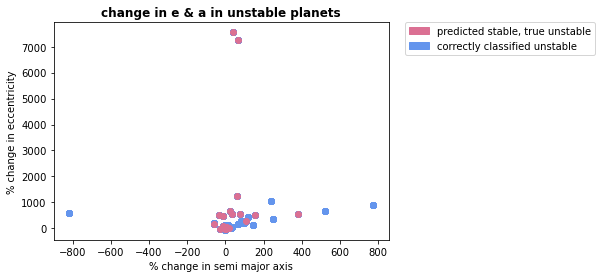

In [172]:
mstu = dict()
c = 0

for rn in range(1,101):
    mstu[rn] = dict()
    
    for planetnum in range(1,11):
        mstu[rn][planetnum] = dict()
            
        pl = genfromtxt(r'/Users/neha/Documents/lanl/classifier/s. mordasini data/run'+str(rn)+'/PL'+str(planetnum)+'.el',skip_header=2, max_rows=1)
        le = len(r'/Users/neha/Documents/lanl/classifier/s. mordasini data/run'+str(rn)+'/PL'+str(planetnum)+'.el')
        pl2 = genfromtxt(r'/Users/neha/Documents/lanl/classifier/s. mordasini data/run'+str(rn)+'/PL'+str(planetnum)+'.el',skip_header=(le-1), max_rows=1)
        
        mstu[rn][planetnum]['initial e'] = pl[3]
        mstu[rn][planetnum]['initial a'] = pl[2]
           
        try:
            mstu[rn][planetnum]['final e'] = pl2[3]
            mstu[rn][planetnum]['final a'] = pl2[2]
            c += 1
        except:
            pass
        
        
        
ca = []
ce = []
wa = []
we = []

for rn in range(1,101):
    for p in range(1,11):
        try:
            if (all_dict[rn, p]['outcome'] == 1) and (all_dict[rn, p]['predict'] == 0):
                wa.append(((mstu[rn][planetnum]['final a'] - mstu[rn][planetnum]['initial a'])/mstu[rn][planetnum]['initial a'])*100)
                we.append(((mstu[rn][planetnum]['final e'] - mstu[rn][planetnum]['initial e'])/mstu[rn][planetnum]['initial e'])*100)

            elif (all_dict[rn, p]['outcome'] == 1) and (all_dict[rn, p]['predict'] == 1):
                ca.append(((mstu[rn][planetnum]['final a'] - mstu[rn][planetnum]['initial a'])/mstu[rn][planetnum]['initial a'])*100)
                ce.append(((mstu[rn][planetnum]['final e'] - mstu[rn][planetnum]['initial e'])/mstu[rn][planetnum]['initial e'])*100)
        except:
            pass
        
        
fig = plt.figure()
plt.title('change in e & a in unstable planets', fontweight='bold')

plt.scatter(ca, ce, color = 'cornflowerblue')
plt.scatter(wa, we, color = 'palevioletred')


plt.ylabel('% change in eccentricity')
plt.xlabel('% change in semi major axis')
# plt.xlim(-100, 600)
# plt.ylim(0,1500)

patch = mpatches.Patch(color='palevioletred', label='predicted stable, true unstable')
patch2 = mpatches.Patch(color='cornflowerblue', label='correctly classified unstable')

plt.legend(handles=[patch, patch2], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  

In [183]:
ccount = 0
wcount = 0

for i in range(len(ca)):
    if (ca[i] > 10 and ce[i] > 10):
        ccount += 1
    
for i in range(len(wa)):
    if (wa[i] > 10 and we[i] > 10):
        wcount += 1

print('correctly classified unstable')
print('median % difference in semi-major axis: ', np.median(ca))
print('median % difference in eccentricity: ', np.median(ce))
print('>10% change in a & e: ', ccount, '/', len(ca))

print('\nmisclassified stable, true unstable')
print('median % difference in semi-major axis: ', np.median(wa))
print('median % difference in eccentricity: ', np.median(we))
print('>10% change in a & e: ', wcount, '/', len(wa))

correctly classified unstable
median % difference in semi-major axis:  0.16181902149969118
median % difference in eccentricity:  22.18661092268713
>10% change in a & e:  164 / 651

misclassified stable, true unstable
median % difference in semi-major axis:  0.0018886110246027618
median % difference in eccentricity:  3.0685988702978935
>10% change in a & e:  10 / 55


## planet number distributions

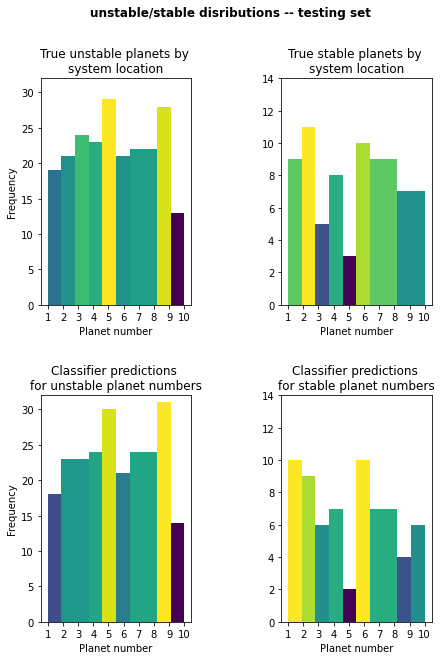

In [100]:
fig = plt.figure(figsize=(7, 10))

r = classifier.predict_proba(features_test) 
s = []
u = []

st = []
ut = []


for i in range(0,len(r)):
    if (classes_predict[i] == 1):
        u.append(p[i])
    if (classes_predict[i] == 0):
        s.append(p[i])

        
for i in range(0,len(r)):
    if (classes_test[i] == 1):
        ut.append(p[i])
    if (classes_test[i] == 0):
        st.append(p[i])        
    

plt.subplot(2, 2, 1)
N, bins, patches = plt.hist(ut, bins = 10)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('Planet number')
plt.xticks(range(1, 11))
plt.ylabel('Frequency')
plt.title('True unstable planets by \nsystem location', loc='center')
plt.ylim(0,32)


plt.subplot(2, 2, 2)
N, bins, patches = plt.hist(st, bins = 10)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('Planet number') 
plt.xticks(range(1, 11))
plt.title('True stable planets by \nsystem location', loc='center')
plt.ylim(0,14)


plt.subplot(2, 2, 3)
N, bins, patches = plt.hist(u, bins = 10)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('Planet number')
plt.xticks(range(1, 11))
plt.ylabel('Frequency')
plt.title('Classifier predictions \nfor unstable planet numbers', loc='center')
plt.ylim(0,32)


plt.subplot(2, 2, 4)
N, bins, patches = plt.hist(s, bins = 10)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('Planet number') 
plt.xticks(range(1, 11))
plt.title('Classifier predictions \nfor stable planet numbers', loc='center')
plt.ylim(0,14)


plt.suptitle('unstable/stable disributions -- testing set', fontweight='bold')
plt.subplots_adjust(wspace=0.6, hspace = 0.4)
plt.show()

### system multiplicity

Text(0, 0.5, 'final system multiplicity')

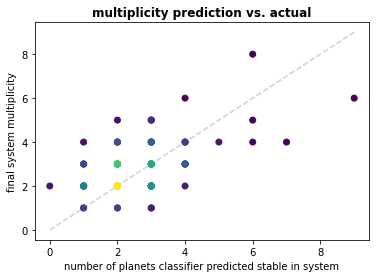

In [138]:
stable_preds = []
multiplicity = []

for r in range(1,101):
    mc = 0
    sc = 0
    
    for p in range(1,11):
        if (all_dict[r, p]['predict'] == 0):
            sc += 1
        if (all_dict[r, p]['outcome'] == 0):
            mc += 1
            
    stable_preds.append(sc)
    multiplicity.append(mc)
    

fig = plt.figure()
plt.title('multiplicity prediction vs. actual', fontweight='bold')


xy = np.vstack([stable_preds, multiplicity])
z = gaussian_kde(xy)(xy)

plt.scatter(stable_preds, multiplicity, c=z)
plt.plot([0,9], [0,9], color='silver', linestyle='dashed', alpha=0.75, zorder=0)

plt.xlabel('number of planets classifier predicted stable in system')
plt.ylabel('final system multiplicity')

Text(0, 0.5, 'final system multiplicity')

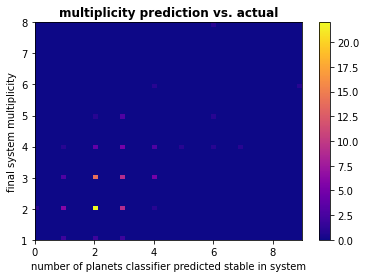

In [144]:
stable_preds = []
multiplicity = []

for r in range(1,101):
    mc = 0
    sc = 0
    
    for p in range(1,11):
        if (all_dict[r, p]['predict'] == 0):
            sc += 1
        if (all_dict[r, p]['outcome'] == 0):
            mc += 1
            
    stable_preds.append(sc)
    multiplicity.append(mc)
   
    
fig = plt.figure()
plt.title('multiplicity prediction vs. actual', fontweight='bold')

plt.hist2d(stable_preds, multiplicity, (50, 50), cmap='plasma') # gist_yarg/binary
plt.colorbar()

plt.xlabel('number of planets classifier predicted stable in system')
plt.ylabel('final system multiplicity')

## changing stability limits

In [102]:
data = dict()

for rn in range(1,101):
    data[rn] = dict()
    for planetnum in range(1,11):
        data[rn][planetnum] = dict()
        pl = genfromtxt(r'/Users/neha/Documents/lanl/classifier/s. mordasini data/run'+str(rn)+'/PL'+str(planetnum)+'.el',skip_header=2, max_rows=365498)
        
        data[rn][planetnum]['Time'] = []
        
        for time in range(len(pl)):
            try:
                data[rn][planetnum]['Time'].append(pl[time][0])
            except:
                data[rn][planetnum]['Time'].append(pl[0])

/Users/neha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/neha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/neha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().d

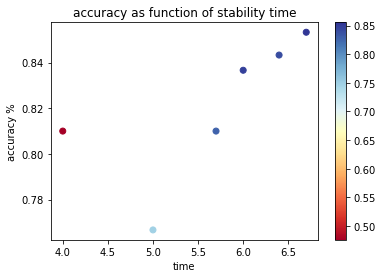

In [116]:
planets = pd.read_csv('2-3 mm.csv', skipinitialspace=True)

# 10000 = 731, 100000 = 7305, 500000 = 36550, 1M = 73100, 5M = 365498

times = [10000, 100000, 500000, 1000000, 2500000, 5000000]
acc = []
cbTe = []


d = ['run', 'planet', 'fate', 'end time', 'initial pericenter',
       'final pericenter', 'mean pericenter', 'min pericenter',
       'max pericenter', 'sd pericenter', 'initial jacobi', 'final jacobi',
       'mean jacobi', 'min jacobi', 'max jacobi', 'sd jacobi', 'final log mass1_ratio',
       'mean log mass1_ratio', 'min log mass1_ratio', 'max log mass1_ratio',
       'sd log mass1_ratio', 'final log mass2_ratio', 
       'mean log mass2_ratio', 'min log mass2_ratio',
       'max log mass2_ratio', 'sd log mass2_ratio']


e = ['e']
mhr1 = ['mhr1']
mhr2 = ['mhr2']
a2 = ['log a2_ratio']

a1 = ['log a1_ratio']
o = ['i', 'a']

for v in mhr1:
    d.append('initial ' + str(v))
    d.append('final ' + str(v))
    d.append('mean ' + str(v))
    d.append('min ' + str(v))
#     d.append('max ' + str(v))
#     d.append('sd ' + str(v))

for v in mhr2:
    d.append('initial ' + str(v))
    d.append('final ' + str(v))
    d.append('mean ' + str(v))
    d.append('min ' + str(v))
    d.append('max ' + str(v))
#     d.append('sd ' + str(v))

for v in e:
    d.append('initial ' + str(v))
    d.append('final ' + str(v))
    d.append('mean ' + str(v))
#     d.append('min ' + str(v))
#     d.append('max ' + str(v))
#     d.append('sd ' + str(v))
    d.append('cv ' + str(v))
    
for v in a2:
    d.append('initial ' + str(v))
    d.append('final ' + str(v))
    d.append('mean ' + str(v))
    d.append('min ' + str(v))
    d.append('max ' + str(v))
    d.append('sd ' + str(v))

for v in a1:
    d.append('initial ' + str(v))
    d.append('final ' + str(v))
#     d.append('mean ' + str(v))
#     d.append('min ' + str(v))
    d.append('max ' + str(v))
#     d.append('sd ' + str(v))

for v in o:
    if v == 'i':
        d.append('initial ' + str(v))
        d.append('final ' + str(v))
        d.append('mean ' + str(v))
        d.append('min ' + str(v))
        d.append('max ' + str(v))
#         d.append('sd ' + str(v))
#         d.append('cv ' + str(v))
    else:
        d.append('cv ' + str(v))



for tind in range(0,6):
    classesC = []
    
    for r in range(1,101):
        for p in range(1,11):
            csys = (r,p)
#             if (csys in incs):
#                 pass
            if (data[r][p]['Time'][len(data[r][p]['Time']) - 1] >= times[tind]):
                classesC += [0]
            else:
                classesC += [1]
        
    classesC = np.array(classesC)
    
    
    featuresC_train, featuresC_test, classesC_train, classesC_test = train_test_split(planets, classesC, test_size=0.3, random_state=7)
    faC = featuresC_train['fate'].to_numpy()

    ids_train = featuresC_train['planet'].to_numpy()
    featuresC_train.drop(d, axis=1, inplace=True)

    cols = featuresC_train.columns
    featuresC_train = featuresC_train.to_numpy()

    ids_test = featuresC_test['planet'].to_numpy()
    featuresC_test.drop(d, axis=1, inplace=True)
    featuresC_test = featuresC_test.to_numpy()


    classifierC = GradientBoostingClassifier(learning_rate = 0.07, max_depth = 5, max_features = 'sqrt', n_estimators = 150, random_state = 183) # ne = 120-160ish
    classifierC.fit(featuresC_train, classesC_train)

    classesC_predict = classifierC.predict(featuresC_test)
    acc.append(accuracy_score(classesC_test, classesC_predict))
    
    
    countC = 0
    cC = 0
    fateC = []
    
    predC = cross_val_predict(classifierC, featuresC_train, classesC_train, cv=10)

    for i in range(len(faC)):
        if (faC[i] == 'remaining'):
            fateC.append(0)
        else:
            fateC.append(1)

            
    for i in range(len(predC)):
        countC += 1
        if (predC[i] == fateC[i]):
            cC += 1
        
    cbTe.append(cC/countC)
    
#     print(times[tind], ' years: accuracy ', accuracy_score(classesC_test, classesC_predict))
    

plt.title('accuracy as function of stability time')
plt.ylabel('accuracy %')
plt.xlabel('time')

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(np.log10(times), acc, c=cbTe, cmap=cm)
plt.colorbar(sc)
plt.show()